targets.shape=(25, 2)


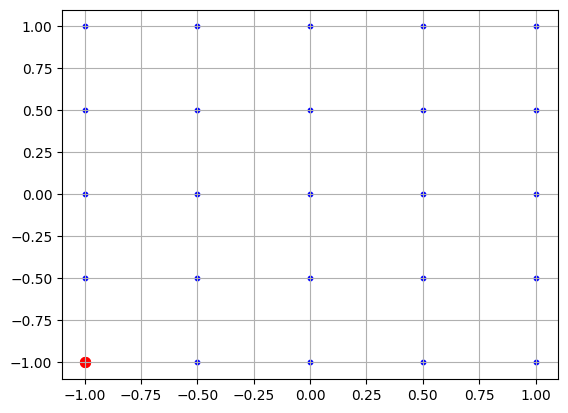

In [1]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np
import math
# Chose number of robots
k = int(4)
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of targets in an axis
n = int(5)

# nodes = targets + depots
# Create a uniform (n*n, 2) numpy target grid for MAXIMUM SPEED
targets = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
targets = targets.reshape(targets.shape + (1,))
targets = np.concatenate((targets[0], targets[1]), axis=2)
targets = targets.reshape((n*n, 2))
target_indices = range(len(targets))
print(f"{targets.shape=}")

# Specify depots
# One depot node in the corner
depots = np.array([
    [-1., -1.],
])
## Four depot nodes (one in each corner)
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.1,
# ])
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.],
# ])
# print(f"{depots=}")
depots = np.concatenate((depots, depots))
depot_indices = range(len(targets), len(targets)+len(depots))

nodes = np.concatenate((targets, depots))
# print(f"{nodes.shape=}")
node_indices = range(len(targets)+len(depots))

# print(f"{list(target_indices)=}\n{list(depot_indices)=}\n{list(node_indices)=}")

# Chose starting depot node
# Make all robots start from same depot
B_k = np.array([depot_indices[0]] * k)
# Make depots start from multiple depots
# B_k = depot_indices[:k]
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(targets[:,0], targets[:,1], c='blue', s=10)
plt.scatter(depots[:,0], depots[:,1], c='red', s=50)
plt.grid()
plt.show()

In [2]:
import itertools

# Calculate c_{i,j} (c[i,j] is the cost (including recharging, q_k) from nodes i to j)
cost = np.zeros((len(node_indices),len(node_indices)))
for i, j in itertools.product(node_indices, node_indices):
    cost[i,j] = np.sqrt((nodes[i,0]-nodes[j,0]) ** 2 + (nodes[i,1]-nodes[j,1]) ** 2)
    # print(f"({i},{j}):({nodes[i,0]},{nodes[i,1]},{nodes[j,0]},{nodes[j,1]}): {cost[i,j]}")
print(f"{cost.shape=}")


cost.shape=(27, 27)


In [3]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# A. Integer Constraints (4), (5)
# Note: All edges are now binary
x = m.addMVar((k,len(node_indices),len(node_indices)), name='x', vtype=GRB.BINARY)
# for ki in range(k):
#     for i in target_indices:
#         for j in target_indices:
#             if i == j: continue
#             _ = m.addConstr(x[ki,i,j] <= 1)
#         for j in depot_indices:
#             _ = m.addConstr(x[ki,i,j] <= 1)
#             _ = m.addConstr(x[ki,j,i] <= 1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2421626
Academic license 2421626 - for non-commercial use only - registered to ce___@wpi.edu


In [4]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:,i,:].sum() >= 1 for i in target_indices)
_ = m.addConstrs(x[:,:,i].sum() >= 1 for i in target_indices)

for ki in range(k):
    # (8) and (9) Begin and end at same position B_k
    # _ = m.addConstr(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() >= 1)
    _ = m.addConstr(x[ki,B_k[ki],:].sum() <= 1)
    # _ = m.addConstr(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() >= 1)
    _ = m.addConstr(x[ki,:,B_k[ki]].sum() <= 1)
    
    # (10) Every robot that visits a target leaves the target
    _ = m.addConstrs((x[ki,:,i]-x[ki,i,:]).sum() == 0 for i in node_indices)

    # Additional constraint: no loopholes!
    _ = m.addConstrs(x[ki, i, i] == 0 for i in node_indices)

In [5]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
p = m.addMVar((k,len(node_indices),len(node_indices)), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

for ki in range(k):
    # (11) and (12) flow constraints
    right_side = 0
    for i, j in itertools.product(target_indices, node_indices):
        right_side += x[ki,i,j]
    _ = m.addConstr((p[ki,B_k[ki],:] - p[ki,:,B_k[ki]]).sum() == right_side)
    
    for i in target_indices:
        _ = m.addConstr((p[ki,:,i] - p[ki,i,:]).sum() == x[ki,i,:].sum())

    # (13) Make sure target capacity doesn't change when passing through a depot
    # Note: Disable for now because we only have one depot which is the starting point
    for i in depot_indices:
        if i == B_k[ki]: continue  # Why? See: https://github.com/NESTLab/mrpcp#linear-constraints
        left_side = 0
        for j in node_indices:
            if i == j: continue
            left_side += p[ki,j,i] - p[ki,i,j]
        _ = m.addConstr(left_side == 0)

    # (14) Ensure that target capacity for each robot doesn't exceed |T|
    _ = m.addConstrs(p[ki,i,j] <= len(target_indices) * x[ki,i,j] for i in node_indices for j in node_indices)

In [6]:
# # D. Fuel Constraints (15), (16), (17), (18), (19), (20)
max_fuel_cost_to_node = np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L = max_fuel_cost_to_node * 2.  # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + max_fuel_cost_to_node
"""
r = m.addMVar((len(node_indices)), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L) # (20)

for ki in range(k):
    # (15) and (16)
    for i, j in itertools.product(target_indices, target_indices):
        left_side = r[j] - r[i] + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side <=  right_side)
        _ = m.addConstr(left_side >= -right_side)

    # (17) and (18)
    for i, j in itertools.product(depot_indices, target_indices):
        left_side = r[j] - L + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side >= -right_side)
        _ = m.addConstr(left_side <=  right_side)

        # (19)
        _ = m.addConstr(r[j] - cost[j,i] >= -M * (1 - x[ki,j,i]))
"""

r = m.addMVar((k,(len(node_indices))), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L) # (20)

for ki in range(k):
    # (15) and (16)
    for i, j in itertools.product(target_indices, target_indices):
        left_side = r[ki,j] - r[ki,i] + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side <=  right_side)
        _ = m.addConstr(left_side >= -right_side)

    # (17) and (18)
    for i, j in itertools.product(depot_indices, target_indices):
        left_side = r[ki,j] - L + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side >= -right_side)
        _ = m.addConstr(left_side <=  right_side)

        # (19)
        _ = m.addConstr(r[ki,j] - cost[j,i] >= -M * (1 - x[ki,j,i]))

In [7]:
# Set objective function (3)
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs((cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

In [8]:
def path_maker(list, currlast):
    firstpass = []
    i = 0
    keepgoing = True
    while i<len(list): #and len(list) != 0:
        if currlast==list[i][0]:
            rem = list.pop(i)
            firstpass.append(rem)
            if firstpass[-1][1] == firstpass[0][0] and firstpass[0][0] != (-1,-1) and firstpass[0][1] != (-1,-1):
                firstpass.append((firstpass[-1][1],(-1,-1)))
                currlast = (-1,-1)
            else:
                currlast = rem[1]
            i = 0
        else:
            i+=1

    return firstpass


In [9]:
class MILPSolver:
    min_cost_edges = None
    min_cost = np.inf
    def __init__(self, model):
        self.model = model
                
    @staticmethod
    def cb(what, where):
        if where == GRB.Callback.MIPSOL and what.cbGet(GRB.Callback.MIPSOL_OBJ) < MILPSolver.min_cost:
            MILPSolver.min_cost = what.cbGet(GRB.Callback.MIPSOL_OBJ)
            print(f"Found a new solution with lower cost({MILPSolver.min_cost:.3f})!")
            
            # If this solution's maximum costing tour ~= the cost of tour that only travels between depot and the furthest node,
            # then, this is guaranteed to be optimal.
            if (MILPSolver.min_cost - max_fuel_cost_to_node * 2) < 0.01:
                print("!This is guaranteed to be the optimal solution!")
                what.terminate()
            
            MILPSolver.min_cost_edges = what.cbGetSolution(what._x)
            #visualize_paths_brute_force(MILPSolver.min_cost_edges)

    def solve(self):
        self.model.optimize(MILPSolver.cb)


In [10]:
m._x = x
m.params.SolutionLimit = 5
solver = MILPSolver(m)
solver.solve()

Set parameter SolutionLimit to value 5
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2421626 - for non-commercial use only - registered to ce___@wpi.edu
Optimize a model with 8902 rows, 5941 columns and 46776 nonzeros
Model fingerprint: 0xc1c1c51b
Variable types: 109 continuous, 5832 integer (2916 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 432 rows and 224 columns
Presolve time: 0.07s
Presolved: 8470 rows, 5717 columns, 45676 nonzeros
Variable types: 101 continuous, 5616 integer (2808 binary)
Found a new solution with lower cost(17.918)!
Found heuristic solution: objective 17.9176032

Root relaxation: objective 3.169706e+00, 5571 iterations, 0.

In [11]:
import datetime

robot_paths = [[] for ki in range(k)]
full_robot_paths = [[] for ki in range(k)]


last_node = 5
robot_to_fail = 0
nodes_to_be_covered = [] #failure
targets_left = [[] for ki in range(k)] #every node left in remaining robots paths that still needs to be covered

already_covered = set()

#generates the route between start and goal
def gen_range(start, goal):
    posorneg = 1 if start<goal else -1    
    count = start+(2/(n-1))*posorneg
    l = []
    if posorneg == 1:
        while count < goal:
            l.append(count)
            count+=(2/(n-1))*posorneg
    else:
        while count > goal:
            l.append(count)
            count+=(2/(n-1))*posorneg
    return l

def visualize_paths_brute_force(edges):
    # Only plot the paths for the robots that were assigned a path
    active_robots = []
    for ki in range(k):
        if (cost * edges[ki]).sum() > 0.01:
            active_robots.append(ki)

    subplot_per_hor_axis = int(np.ceil(np.sqrt(len(active_robots))))
    subplot_per_vert_axis = int(np.ceil(len(active_robots) / subplot_per_hor_axis))
    fig, axs = plt.subplots(subplot_per_hor_axis, subplot_per_vert_axis, figsize=(subplot_per_hor_axis * 4, subplot_per_vert_axis * 4))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1, top=0.9, right=0.9, left=0.1, wspace=0.3, hspace=0.3)

    hor_i = 0
    vert_i = 0
    for robot_i, ki in enumerate(active_robots):
        if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
            ax = axs
        elif subplot_per_vert_axis == 1:
            ax = axs[hor_i]
        else:
            ax = axs[hor_i][vert_i]
        ax.set_title(f"Robot #{robot_i+1} (cost={(cost * edges[ki]).sum():.3f})")
        ax.scatter(targets[:,0], targets[:,1], c='blue', s=10)
        ax.scatter(depots[:,0], depots[:,1], c='red', s=50)
        ax.scatter(nodes[B_k[ki], 0], nodes[B_k[ki], 1], c='red', s=100)
        node_list = []
        for i, j in itertools.product(node_indices, node_indices):
            if edges[ki,i,j] > 0.5:  # In case there is any floating math errors
                node_list.append(((nodes[i, 0], nodes[i, 1]), (nodes[j, 0], nodes[j, 1])))
                ax.scatter(nodes[i, 0], nodes[i, 1], c="purple", s=8)
                ax.scatter(nodes[j, 0], nodes[j, 1], c="purple", s=8)
                ax.plot([nodes[i, 0], nodes[j, 0]], [nodes[i, 1], nodes[j, 1]], color="purple", linewidth=1)
            
                dx = nodes[j][0]-nodes[i][0]
                dy = nodes[j][1]-nodes[i][1] 

                if dy == 0:
                    for s in gen_range(nodes[j][0], nodes[i][0]):
                        already_covered.add((s,nodes[j][1]))
                elif dx == 0:
                    for s in gen_range(nodes[j][1], nodes[i][1]):
                        already_covered.add((nodes[j][0], s))
                elif dx == dy:
                    for s in gen_range(nodes[j][1], nodes[i][1]):
                        already_covered.add((s, s)) 
                        
        robot_paths[ki] = node_list 
        full_robot_paths[ki] = path_maker(robot_paths[ki], robot_paths[ki][0][1])        
        #ax.scatter(full_robot_paths[ki][last_node][0][0], full_robot_paths[ki][last_node][0][1], c="orange", s=40)
        
        for i in range(last_node+1, len(full_robot_paths[robot_to_fail])):
            if full_robot_paths[robot_to_fail][i][0] != (-1,-1):
                ax.scatter(full_robot_paths[robot_to_fail][i][0][0], full_robot_paths[robot_to_fail][i][0][1], c="yellow", s=40)
                if ki == robot_to_fail:    
                    nodes_to_be_covered.append(full_robot_paths[robot_to_fail][i][0])

        
        if ki != robot_to_fail:   
            for i in range(last_node, len(full_robot_paths[ki])):
                targets_left[ki].append(full_robot_paths[ki][i][0])
                already_covered.add(full_robot_paths[ki][i][0])
                if full_robot_paths[ki][i][0] != (-1,-1):
                    ax.scatter(full_robot_paths[ki][i][0][0], full_robot_paths[ki][i][0][1], c="orange", s=20)
                 
        vert_i += 1
        if vert_i >= subplot_per_vert_axis:
            vert_i = 0
            hor_i += 1
        ax.grid()
    
    for h in range(subplot_per_hor_axis):
        for v in range(subplot_per_vert_axis):
            if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
                ax = axs
            elif subplot_per_vert_axis == 1:
                ax = axs[h]
            else:
                ax = axs[h][v]
            ax.set_box_aspect(1)
    
    fig.suptitle(f"Paths for all robots (# of active/available robots={len(active_robots)}/{k}, sum of costs={(cost * edges).sum():.3f})")
    #fig.savefig(f"../../data/2015_mrpcp_k={k}_n={n}_{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}.png") 
    plt.show()

[((-1.0, -1.0), (-1.0, -1.0)), ((-1.0, -1.0), (-1.0, -1.0)), ((-1.0, -1.0), (-1.0, -1.0)), ((-1.0, -1.0), (-0.5, 0.0)), ((-0.5, 0.0), (-0.5, 0.5)), ((-0.5, 0.5), (-1.0, 0.5)), ((-1.0, 0.5), (-1.0, 1.0)), ((-1.0, 1.0), (-0.5, 1.0)), ((-0.5, 1.0), (-1.0, -1.0)), ((-1.0, -1.0), (1.0, 0.5)), ((1.0, 0.5), (0.5, 0.5)), ((0.5, 0.5), (0.0, 0.5)), ((0.0, 0.5), (0.0, 0.0)), ((0.0, 0.0), (-1.0, -1.0)), ((-1.0, -1.0), (-1.0, -1.0))]
[((-1.0, -1.0), (-1.0, -1.0)), ((-1.0, -1.0), (-1.0, -0.5)), ((-1.0, -0.5), (-1.0, -1.0)), ((-1.0, -1.0), (-1.0, 0.0)), ((-1.0, 0.0), (-1.0, -1.0)), ((-1.0, -1.0), (-0.5, -1.0)), ((-0.5, -1.0), (0.0, -1.0)), ((0.0, -1.0), (0.5, -1.0)), ((0.5, -1.0), (0.5, -0.5)), ((0.5, -0.5), (0.0, -0.5)), ((0.0, -0.5), (-0.5, -0.5)), ((-0.5, -0.5), (-1.0, -1.0)), ((-1.0, -1.0), (-1.0, -1.0))]
1 13
[((-1.0, -1.0), (-1.0, -1.0)), ((-1.0, -1.0), (0.0, 1.0)), ((0.0, 1.0), (0.5, 1.0)), ((0.5, 1.0), (-0.5, 0.5)), ((-0.5, 0.5), (-1.0, -1.0)), ((-1.0, -1.0), (0.5, 0.0)), ((0.5, 0.0), (1.0, 0

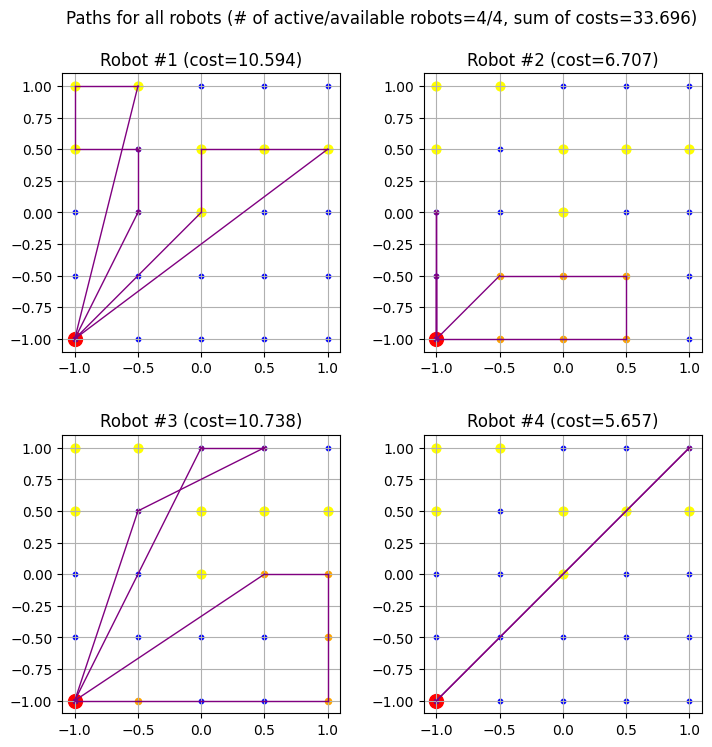

[[], [(-1.0, -1.0), (-0.5, -1.0), (0.0, -1.0), (0.5, -1.0), (0.5, -0.5), (0.0, -0.5), (-0.5, -0.5), (-1.0, -1.0)], [(-1.0, -1.0), (0.5, 0.0), (1.0, 0.0), (1.0, -0.5), (1.0, -1.0), (-0.5, -1.0)], []]


<generator object <genexpr> at 0x7f49d9ef1c60>

In [12]:
visualize_paths_brute_force(MILPSolver.min_cost_edges)
print(targets_left)

(already_covered.add(x) for t in targets_left for x in t)   
#print(nodes_to_be_covered)
# visualize_paths_faster(MILPSolver.min_cost_edges)

In [13]:
import math
min_pos = (-1,-1)
bot = -1

final = [[] for ki in range(k)]
#will need to add something here to deal with the fact that you won't always be able to add nicely to these paths
#need to make this st it appends to the list    
#just go through and add a node to each position
for node in nodes_to_be_covered: #for each node that needs to be covered
    if node not in already_covered:
        final_min_pos = (-1,-1)
        final_min_dist = max_fuel_cost_to_node
        bot = 0
        bot_count = 0
        for robot_path in targets_left: #for each potential target node path (remaining nodes each robot has to cover)
            min_dist = max_fuel_cost_to_node
            min_pos = (-1,-1)
            for target in robot_path: #find the closest node to node that needs to be covered in robots current path
                if math.dist(target, node) < min_dist:
                    min_dist = math.dist(target, node)
                    min_pos = target
            if min_dist < final_min_dist:
                final_min_dist = min_dist
                final_min_pos = min_pos
                bot = bot_count
            bot_count+=1
        final[bot].append((final_min_pos, node))

FINAL
(-0.5, -0.5)
node (-1.0, 0.5)
1
FINAL
(-0.5, -0.5)
node (-1.0, 1.0)
1
FINAL
(0.5, 0.0)
node (-0.5, 1.0)
2
FINAL
(1.0, 0.0)
node (1.0, 0.5)
2
FINAL
(0.5, 0.0)
node (0.0, 0.5)
2
{(0.5, -0.5), (-0.5, -1.0), (0.5, 0.0), (0.5, 0.5), (-1.0, -1.0), (0.0, -0.5), (0.0, 0.0), (-0.5, -0.5), (1.0, -1.0), (-1.0, -0.5), (1.0, -0.5), (0.5, -1.0), (1.0, 0.0), (0.0, -1.0)}


In [14]:
def get_fuel_level(k, x, y):
    val = (math.floor(x/0.5)+2)*5 + math.floor(y/0.5)+2
    return r[k, val].X

def get_fuel_cost_to_finish_tour(k):
    total_cost = 0
    x = 0
    while x < len(targets_left[k]) - 1 and targets_left[k][x] != (-1,-1):
        total_cost += math.dist(targets_left[k][x], targets_left[k][x+1])
        x+=1
    return total_cost
    
for ki in range(k):
    for f in final[ki]:
        if len(final[ki]) != 0:    
            if get_fuel_level(ki, targets_left[ki][0][0], targets_left[ki][0][1]) > get_fuel_cost_to_finish_tour(ki) + math.dist(f[0],f[1]):
                targets_left[ki].insert(targets_left[ki].index(f[0])+1, f[1])
            else:
                subtour = [(-1,-1), f[1], (-1,-1)]
                [targets_left[ki].append(s) for s in subtour]
        
[targets_left[ki].append((-1,-1)) for ki in range(k)]

            #add a refueling tour, then go to point

((-0.5, -0.5), (-1.0, 0.5))
((-0.5, -0.5), (-1.0, 1.0))
((0.5, 0.0), (-0.5, 1.0))
((1.0, 0.0), (1.0, 0.5))
((0.5, 0.0), (0.0, 0.5))
[[], [(-1.0, -1.0), (-0.5, -1.0), (0.0, -1.0), (0.5, -1.0), (0.5, -0.5), (0.0, -0.5), (-0.5, -0.5), (-1.0, 1.0), (-1.0, 0.5), (-1.0, -1.0)], [(-1.0, -1.0), (0.5, 0.0), (1.0, 0.0), (1.0, -0.5), (1.0, -1.0), (-0.5, -1.0), (-1, -1), (-0.5, 1.0), (-1, -1), (-1, -1), (1.0, 0.5), (-1, -1), (-1, -1), (0.0, 0.5), (-1, -1)], []]
[[(-1, -1)], [(-1.0, -1.0), (-0.5, -1.0), (0.0, -1.0), (0.5, -1.0), (0.5, -0.5), (0.0, -0.5), (-0.5, -0.5), (-1.0, 1.0), (-1.0, 0.5), (-1.0, -1.0), (-1, -1)], [(-1.0, -1.0), (0.5, 0.0), (1.0, 0.0), (1.0, -0.5), (1.0, -1.0), (-0.5, -1.0), (-1, -1), (-0.5, 1.0), (-1, -1), (-1, -1), (1.0, 0.5), (-1, -1), (-1, -1), (0.0, 0.5), (-1, -1), (-1, -1)], [(-1, -1)]]


In [17]:
import datetime

def visualize_after_failure(edges):
    # Only plot the paths for the robots that were assigned a path
    active_robots = []
    for ki in range(k):
        if (cost * edges[ki]).sum() > 0.01:
            active_robots.append(ki)

    subplot_per_hor_axis = int(np.ceil(np.sqrt(len(active_robots))))
    subplot_per_vert_axis = int(np.ceil(len(active_robots) / subplot_per_hor_axis))
    fig, axs = plt.subplots(subplot_per_hor_axis, subplot_per_vert_axis, figsize=(subplot_per_hor_axis * 4, subplot_per_vert_axis * 4))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1, top=0.9, right=0.9, left=0.1, wspace=0.3, hspace=0.3)

    hor_i = 0
    vert_i = 0
    for robot_i, ki in enumerate(active_robots):
        if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
            ax = axs
        elif subplot_per_vert_axis == 1:
            ax = axs[hor_i]
        else:
            ax = axs[hor_i][vert_i]
        ax.set_title(f"Robot #{robot_i+1}")
        ax.scatter(targets[:,0], targets[:,1], c='blue', s=10)
        ax.scatter(depots[:,0], depots[:,1], c='red', s=50)
        ax.scatter(nodes[B_k[ki], 0], nodes[B_k[ki], 1], c='red', s=100)

        if(len(full_robot_paths[ki]) != 0):
            for x in range(len(targets_left[ki])-1):
                ax.scatter(targets_left[ki][x][0], targets_left[ki][x][1], c='purple', s=10)
                ax.arrow(targets_left[ki][x][0], targets_left[ki][x][1], (targets_left[ki][x+1][0]-targets_left[ki][x][0]), (targets_left[ki][x+1][1]-targets_left[ki][x][1]), color="purple", head_width=0.05, length_includes_head = True)
    
            for i in range(last_node+1, len(full_robot_paths[robot_to_fail])):
                if full_robot_paths[robot_to_fail][i][0] != (-1,-1) and full_robot_paths[robot_to_fail][i][0] not in already_covered:
                    ax.scatter(full_robot_paths[robot_to_fail][i][0][0], full_robot_paths[robot_to_fail][i][0][1], c="yellow", s=40)
                
        vert_i += 1
        if vert_i >= subplot_per_vert_axis:
            vert_i = 0
            hor_i += 1
        ax.grid()
    
    for h in range(subplot_per_hor_axis):
        for v in range(subplot_per_vert_axis):
            if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
                ax = axs
            elif subplot_per_vert_axis == 1:
                ax = axs[h]
            else:
                ax = axs[h][v]
            ax.set_box_aspect(1)
    
    fig.suptitle(f"Paths for all robots (# of active/available robots={len(active_robots)}/{k}, sum of costs={(cost * edges).sum():.3f})")
    #fig.savefig(f"../../data/2015_mrpcp_k={k}_n={n}_{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}.png") 
    plt.show()



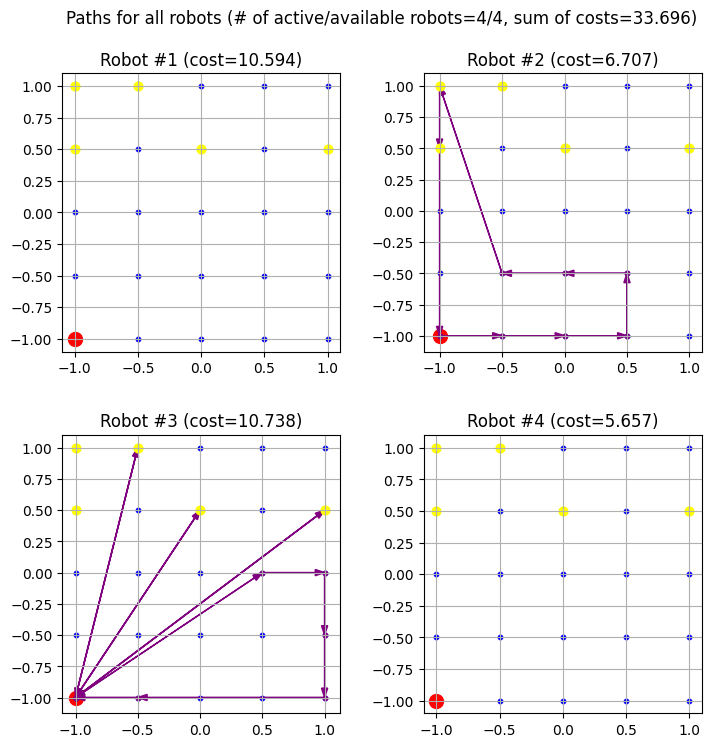

[[(-1, -1)], [(-1.0, -1.0), (-0.5, -1.0), (0.0, -1.0), (0.5, -1.0), (0.5, -0.5), (0.0, -0.5), (-0.5, -0.5), (-1.0, 1.0), (-1.0, 0.5), (-1.0, -1.0), (-1, -1)], [(-1.0, -1.0), (0.5, 0.0), (1.0, 0.0), (1.0, -0.5), (1.0, -1.0), (-0.5, -1.0), (-1, -1), (-0.5, 1.0), (-1, -1), (-1, -1), (1.0, 0.5), (-1, -1), (-1, -1), (0.0, 0.5), (-1, -1), (-1, -1)], [(-1, -1)]]
5.656854249492381


In [19]:
visualize_after_failure(MILPSolver.min_cost_edges)
print(targets_left)
print(L)